In [60]:
import time
import psycopg2
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from finance.utilities import utils
from finance.science.utilities import lstm_utils, options_utils, science_utils

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get stock data

In [34]:
date_start = '2015-01-01'
date_end = '2021-01-01'
query = f'''
    with 
    tickers as (
        select distinct 
            ticker
            , sector
            , industry
        from nasdaq.listed_stocks
        where ticker !~ '[\^.~]'
            and character_length(ticker) between 1 and 4
            and ticker in ('KO', 'JPM', 'AA')
        limit 30
        )
    , lagged as (
        select
            symbol
            , market_datetime
            , max(open) over (partition by symbol order by market_datetime rows between 1 following and 31 following) as open
            , open as _open
            , lag(open, 1) over (partition by symbol order by market_datetime) as open_1
            , lag(open, 2) over (partition by symbol order by market_datetime) as open_2
            , lag(open, 3) over (partition by symbol order by market_datetime) as open_3
            , lag(open, 4) over (partition by symbol order by market_datetime) as open_4
            , lag(open, 5) over (partition by symbol order by market_datetime) as open_5
            , lag(open, 6) over (partition by symbol order by market_datetime) as open_6
            , lag(open, 7) over (partition by symbol order by market_datetime) as open_7
            , lag(open, 8) over (partition by symbol order by market_datetime) as open_8
            , lag(open, 9) over (partition by symbol order by market_datetime) as open_9
            , lag(open, 10) over (partition by symbol order by market_datetime) as open_10
            , lag(open, 11) over (partition by symbol order by market_datetime) as open_11
            , lag(open, 12) over (partition by symbol order by market_datetime) as open_12
            , lag(open, 13) over (partition by symbol order by market_datetime) as open_13
            , lag(open, 14) over (partition by symbol order by market_datetime) as open_14
            , lag(open, 15) over (partition by symbol order by market_datetime) as open_15
            , lag(open, 16) over (partition by symbol order by market_datetime) as open_16
            , lag(open, 17) over (partition by symbol order by market_datetime) as open_17
            , lag(open, 18) over (partition by symbol order by market_datetime) as open_18
            , lag(open, 19) over (partition by symbol order by market_datetime) as open_19
            , lag(open, 20) over (partition by symbol order by market_datetime) as open_20
            , lag(open, 21) over (partition by symbol order by market_datetime) as open_21
            , lag(open, 22) over (partition by symbol order by market_datetime) as open_22
            , lag(open, 23) over (partition by symbol order by market_datetime) as open_23
            , lag(open, 24) over (partition by symbol order by market_datetime) as open_24
            , lag(open, 25) over (partition by symbol order by market_datetime) as open_25
            , lag(open, 26) over (partition by symbol order by market_datetime) as open_26
            , lag(open, 27) over (partition by symbol order by market_datetime) as open_27
            , lag(open, 28) over (partition by symbol order by market_datetime) as open_28
            , lag(open, 29) over (partition by symbol order by market_datetime) as open_29
            , lag(open, 30) over (partition by symbol order by market_datetime) as open_30
        from td.equities as equities
        inner join tickers
            on tickers.ticker = equities.symbol
        where market_datetime > '{date_start}' and market_datetime < '{date_end}'
        )
    , summarized as (
        select *
            , least(open_1, open_2, open_3, open_4, open_5, open_6, open_7, open_8, open_9, open_10, open_11, open_12, open_13, open_14, open_15, open_16, open_17, open_18, open_19, open_20, open_21, open_22, open_23, open_24, open_25, open_26, open_27, open_28, open_29, open_30) as open_min
            , greatest(open_1, open_2, open_3, open_4, open_5, open_6, open_7, open_8, open_9, open_10, open_11, open_12, open_13, open_14, open_15, open_16, open_17, open_18, open_19, open_20, open_21, open_22, open_23, open_24, open_25, open_26, open_27, open_28, open_29, open_30) as open_max
        from lagged
        where open_30 is not null
        )
    select
            symbol
            , market_datetime
            , open as denormalized_open
            , _open
            , open_min
            , open_max
            , (open - open_min) / (open_max - open_min) as open
            , (open_1 - open_min) / (open_max - open_min) as open_1
            , (open_2 - open_min) / (open_max - open_min) as open_2
            , (open_3 - open_min) / (open_max - open_min) as open_3
            , (open_4 - open_min) / (open_max - open_min) as open_4
            , (open_5 - open_min) / (open_max - open_min) as open_5
            , (open_6 - open_min) / (open_max - open_min) as open_6
            , (open_7 - open_min) / (open_max - open_min) as open_7
            , (open_8 - open_min) / (open_max - open_min) as open_8
            , (open_9 - open_min) / (open_max - open_min) as open_9
            , (open_10 - open_min) / (open_max - open_min) as open_10
            , (open_11 - open_min) / (open_max - open_min) as open_11
            , (open_12 - open_min) / (open_max - open_min) as open_12
            , (open_13 - open_min) / (open_max - open_min) as open_13
            , (open_14 - open_min) / (open_max - open_min) as open_14
            , (open_15 - open_min) / (open_max - open_min) as open_15
            , (open_16 - open_min) / (open_max - open_min) as open_16
            , (open_17 - open_min) / (open_max - open_min) as open_17
            , (open_18 - open_min) / (open_max - open_min) as open_18
            , (open_19 - open_min) / (open_max - open_min) as open_19
            , (open_20 - open_min) / (open_max - open_min) as open_20
            , (open_21 - open_min) / (open_max - open_min) as open_21
            , (open_22 - open_min) / (open_max - open_min) as open_22
            , (open_23 - open_min) / (open_max - open_min) as open_23
            , (open_24 - open_min) / (open_max - open_min) as open_24
            , (open_25 - open_min) / (open_max - open_min) as open_25
            , (open_26 - open_min) / (open_max - open_min) as open_26
            , (open_27 - open_min) / (open_max - open_min) as open_27
            , (open_28 - open_min) / (open_max - open_min) as open_28
            , (open_29 - open_min) / (open_max - open_min) as open_29
            , (open_30 - open_min) / (open_max - open_min) as open_30
    from summarized
    order by market_datetime, symbol
    '''

df = utils.query_db(query=query)
df.head()

,symbol,market_datetime,denormalized_open,_open,open_min,open_max,open,open_1,open_2,open_3,...,open_21,open_22,open_23,open_24,open_25,open_26,open_27,open_28,open_29,open_30
0,AA,2015-02-17 06:00:00,47.79,47.520000,44.880003,51.000003,0.475490,0.411765,0.367647,0.382353,...,0.098038,0.245097,0.740196,0.705882,0.524509,0.343137,0.156862,0.029412,0.333332,0.446078
1,JPM,2015-02-17 06:00:00,62.20,59.360000,54.530000,62.620000,0.948084,0.609394,0.543881,0.436341,...,0.148331,0.294190,0.584672,0.587145,0.765142,0.672435,0.662546,0.755253,0.930779,1.000000
2,KO,2015-02-17 06:00:00,43.12,41.810000,41.210000,43.600000,0.799163,0.338912,0.497908,0.372385,...,0.677824,0.364017,0.677824,0.778243,0.945607,0.824268,0.665272,0.502092,0.619247,0.439331
3,AA,2015-02-18 06:00:00,47.79,47.189997,44.880003,51.000003,0.475490,0.431372,0.411765,0.367647,...,0.000000,0.098038,0.245097,0.740196,0.705882,0.524509,0.343137,0.156862,0.029412,0.333332
4,JPM,2015-02-18 06:00:00,62.20,59.790000,54.530000,62.060000,1.018592,0.641434,0.654714,0.584329,...,0.017264,0.159363,0.316069,0.628154,0.630810,0.822045,0.722444,0.711819,0.811421,1.000000


### Clean data

In [35]:
SYMBOL = 'symbol'

OPEN = 'open'
_OPEN = '_open'
OPEN_MIN = 'open_min'
OPEN_MAX = 'open_max'

PREDICTION = 'prediction'
DENORMALIZED_OPEN = 'denormalized_open'
DENORMALIZED_PREDICTION = 'denormalized_prediction'

COLS_TO_IGNORE = [SYMBOL, 'market_datetime', DENORMALIZED_OPEN, OPEN, _OPEN, OPEN_MIN, OPEN_MAX]

In [36]:
df = science_utils.encode_one_hot(df, [SYMBOL])
df.head(10)

,symbol,market_datetime,denormalized_open,_open,open_min,open_max,open,open_1,open_2,open_3,...,open_24,open_25,open_26,open_27,open_28,open_29,open_30,symbol_AA,symbol_JPM,symbol_KO
0,AA,2015-02-17 06:00:00,47.79,47.520000,44.880003,51.000003,0.475490,0.411765,0.367647,0.382353,...,0.705882,0.524509,0.343137,0.156862,0.029412,0.333332,0.446078,1,0,0
1,JPM,2015-02-17 06:00:00,62.20,59.360000,54.530000,62.620000,0.948084,0.609394,0.543881,0.436341,...,0.587145,0.765142,0.672435,0.662546,0.755253,0.930779,1.000000,0,1,0
2,KO,2015-02-17 06:00:00,43.12,41.810000,41.210000,43.600000,0.799163,0.338912,0.497908,0.372385,...,0.778243,0.945607,0.824268,0.665272,0.502092,0.619247,0.439331,0,0,1
3,AA,2015-02-18 06:00:00,47.79,47.189997,44.880003,51.000003,0.475490,0.431372,0.411765,0.367647,...,0.740196,0.705882,0.524509,0.343137,0.156862,0.029412,0.333332,1,0,0
4,JPM,2015-02-18 06:00:00,62.20,59.790000,54.530000,62.060000,1.018592,0.641434,0.654714,0.584329,...,0.628154,0.630810,0.822045,0.722444,0.711819,0.811421,1.000000,0,1,0
5,KO,2015-02-18 06:00:00,43.12,41.750000,41.210000,43.600000,0.799163,0.251046,0.338912,0.497908,...,0.677824,0.778243,0.945607,0.824268,0.665272,0.502092,0.619247,0,0,1
6,AA,2015-02-19 06:00:00,47.79,47.340000,44.880003,51.000003,0.475490,0.377450,0.431372,0.411765,...,0.245097,0.740196,0.705882,0.524509,0.343137,0.156862,0.029412,1,0,0
7,JPM,2015-02-19 06:00:00,62.20,59.150000,54.530000,60.720000,1.239095,0.849758,0.780291,0.796446,...,0.384491,0.764136,0.767367,1.000000,0.878837,0.865913,0.987076,0,1,0
8,KO,2015-02-19 06:00:00,43.12,41.680000,41.210000,43.600000,0.799163,0.225941,0.251046,0.338912,...,0.364017,0.677824,0.778243,0.945607,0.824268,0.665272,0.502092,0,0,1
9,AA,2015-02-20 06:00:00,46.98,47.790000,44.880003,51.000003,0.343137,0.401960,0.377450,0.431372,...,0.098038,0.245097,0.740196,0.705882,0.524509,0.343137,0.156862,1,0,0


### Train lstm

In [37]:
size = int(round(len(df)/2, -2))

train = df.head(size)
test = df.tail(int(size/2))

Batch 1, Epoch 0, Loss 2513.6708984375
Batch 1, Epoch 25, Loss 2261.53759765625
Batch 1, Epoch 50, Loss 1438.26904296875
Batch 1, Epoch 75, Loss 1106.9716796875
Batch 1, Epoch 100, Loss 1056.9488525390625
Batch 1, Epoch 125, Loss 1028.0318603515625
Batch 1, Epoch 150, Loss 1010.50341796875
Batch 1, Epoch 175, Loss 996.7163696289062
Batch 1, Epoch 200, Loss 986.9613037109375
Batch 1, Epoch 225, Loss 978.42041015625


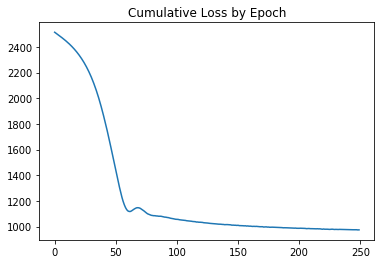

In [38]:
model = lstm_utils.TorchLSTM(
    train_x=train.drop(COLS_TO_IGNORE, axis=1),
    train_y=train[OPEN],
    test_x=test.drop(COLS_TO_IGNORE, axis=1),
    test_y=test[OPEN],
    n_layers=2,
    n_training_batches=1,
    n_epochs=250,
    hidden_shape=1000,
    dropout=0.1,
    learning_rate=.0001,
    seed=44,
)

model.fit()
prediction = model.prediction_df

In [39]:
res = test[COLS_TO_IGNORE].join(prediction)

res[DENORMALIZED_PREDICTION] = res[PREDICTION] * (df[OPEN_MAX] - df[OPEN_MIN]) + df[OPEN_MIN]
res.head()

,symbol,market_datetime,denormalized_open,open,_open,open_min,open_max,open_1,open_2,open_3,...,open_26,open_27,open_28,open_29,open_30,symbol_AA,symbol_JPM,symbol_KO,prediction,denormalized_prediction
3095,KO,2019-03-22 05:00:00,48.95,0.854617,45.46,44.60,49.69,0.182711,0.157171,0.186640,...,0.984283,1.000000,0.976424,0.937132,0.897839,0,0,1,0.621012,47.760952
3096,AA,2019-03-25 05:00:00,29.55,0.647332,28.12,26.76,31.07,0.542923,0.412993,0.403712,...,0.457077,0.475638,0.364269,0.183295,0.083527,1,0,0,0.865715,30.491232
3097,JPM,2019-03-25 05:00:00,116.43,2.277950,99.59,101.76,108.20,0.009317,0.268634,0.725155,...,0.110248,0.177019,0.029503,0.000000,0.049689,0,1,0,0.862929,107.317262
3098,KO,2019-03-25 05:00:00,48.95,0.854617,45.86,44.60,49.69,0.168959,0.182711,0.157171,...,0.412574,0.984283,1.000000,0.976424,0.937132,0,0,1,0.608044,47.694944
3099,AA,2019-03-26 05:00:00,29.55,0.647332,28.14,26.76,31.07,0.315545,0.542923,0.412993,...,0.452436,0.457077,0.475638,0.364269,0.183295,1,0,0,0.853112,30.436914


### Evaluate predictions

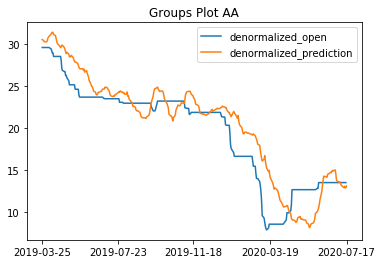

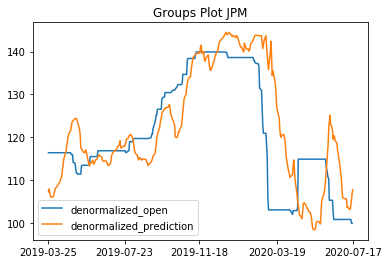

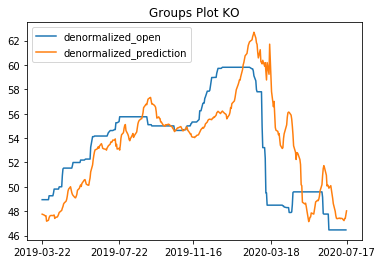

In [40]:
science_utils.plot_groups(res, SYMBOL, [DENORMALIZED_OPEN, DENORMALIZED_PREDICTION])

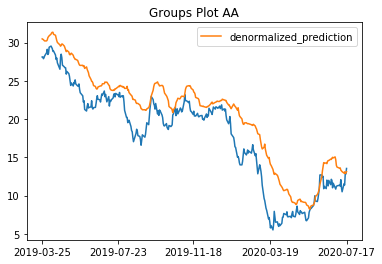

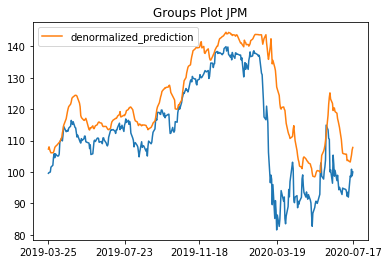

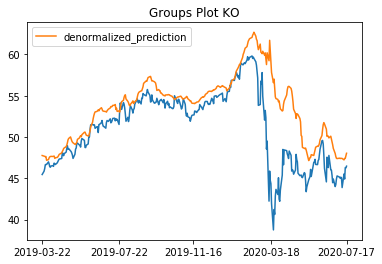

In [41]:
science_utils.plot_groups(res, SYMBOL, [_OPEN, DENORMALIZED_PREDICTION])

### Get options data

In [42]:
date_start = '2020-07-01'
query = f'''
    with 
    tickers as (
        select distinct 
            ticker
            , sector
            , industry
        from nasdaq.listed_stocks
        where ticker !~ '[\^.~]'
            and character_length(ticker) between 1 and 4
            and ticker in ('KO', 'JPM', 'AA')
        limit 30
        )
    select
        symbol
        , file_datetime
        , put_call
        , strike
        , days_to_expiration
        , last
        , (bid + ask) / 2 as bid_ask
    from td.options_raw
    inner join tickers
        on tickers.ticker = options_raw.symbol
    where file_datetime > '{date_start}'
    order by file_datetime, symbol, put_call, strike, days_to_expiration
    '''

options = utils.query_db(query=query)
options.head()

,symbol,file_datetime,put_call,strike,days_to_expiration,last,bid_ask
0,AA,2020-07-01 21:50:46,CALL,1.0,1.0,11.11,10.175
1,AA,2020-07-01 21:50:46,CALL,1.0,9.0,0.00,10.275
2,AA,2020-07-01 21:50:46,CALL,1.0,16.0,6.67,9.975
3,AA,2020-07-01 21:50:46,CALL,1.0,23.0,0.00,10.075
4,AA,2020-07-01 21:50:46,CALL,1.0,107.0,0.00,10.075


In [101]:
x = options.iloc[74]

bs = options_utils.BlackScholes(
    current_option_price=x['bid_ask'],
    stock_price=res.loc[(res[SYMBOL] == x[SYMBOL]) & (res['market_datetime'].dt.date == x['file_datetime'].date()), DENORMALIZED_OPEN],
    strike=x['strike'],
    risk_free_rate=.0001,
    days_to_maturity=x['days_to_expiration'],
    is_call=x['put_call']=='CALL',
)

In [102]:
bs.implied_volatility

9.531364327373954e-13